# Demonstration of Core Functions of Climpyrical

In [1]:
from climpyrical.datacube import read_data
from climpyrical.mask import rotate_shapefile, gen_raster_mask_from_vector
from climpyrical.gridding import transform_coords, find_element_wise_nearest_pos, flatten_coords, find_nearest_index_value
from pkg_resources import resource_filename

import os

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Load Rain Load Ensemble 

In [2]:
storage = resource_filename("climpyrical", "tests/data/snw_test_ensemble.nc")
dv = "Rain-RL50"
ds = read_data(storage, dv)

In [3]:
ds

<xarray.Dataset>
Dimensions:       (level: 35, rlat: 130, rlon: 155)
Coordinates:
    lon           (rlat, rlon) float64 ...
    lat           (rlat, rlon) float64 ...
  * rlon          (rlon) float64 -33.88 -33.44 -33.0 -32.56 ... 33.0 33.44 33.88
  * rlat          (rlat) float64 -28.6 -28.16 -27.72 ... 27.28 27.72 28.16
  * level         (level) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0
Data variables:
    rotated_pole  int32 ...
    Rain-RL50     (level, rlat, rlon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Wed Sep 11 11:06:46 2019: cdo setmissval,1.00000002004088e+...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...

In [4]:
type(ds)

xarray.core.dataset.Dataset

In [5]:
ds[dv]

<xarray.DataArray 'Rain-RL50' (level: 35, rlat: 130, rlon: 155)>
[705250 values with dtype=float32]
Coordinates:
    lon      (rlat, rlon) float64 ...
    lat      (rlat, rlon) float64 ...
  * rlon     (rlon) float64 -33.88 -33.44 -33.0 -32.56 ... 33.0 33.44 33.88
  * rlat     (rlat) float64 -28.6 -28.16 -27.72 -27.28 ... 27.28 27.72 28.16
  * level    (level) float64 1.0 2.0 3.0 4.0 5.0 ... 31.0 32.0 33.0 34.0 35.0
Attributes:
    standard_name:  RL50years_Rain
    long_name:      RL50_Annual maximum Rain
    units:          kPas
    grid_mapping:   rotated_pole

### Mask the ensemble
Load a vector from Natural Earth of each country, extract Canada's geometry using GeoPandas

In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
can_index = world[world.name == "Canada"].index
can_geom = world.loc[can_index, 'geometry']

canada = rotate_shapefile(can_geom)

Examine the new rotated field

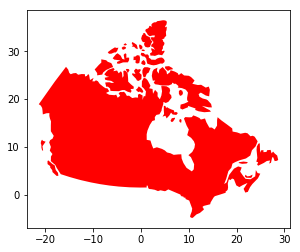

In [7]:
canada.plot(color='red')

In [8]:
mask = gen_raster_mask_from_vector(ds.rlon.values, ds.rlat.values, canada)

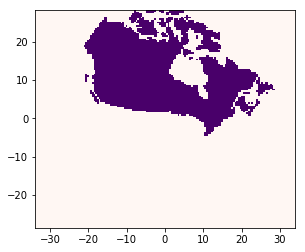

In [9]:
plt.imshow(mask, origin='lower', cmap=plt.cm.RdPu, extent=[ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()])

Let's take the mean of the 35 member ensemble

In [10]:
# Show the shape
ds[dv].shape

(35, 130, 155)

In [11]:
# Take mean
ens_mean = ds[dv].values.mean(axis=0)
# Show the shape
ens_mean.shape

(130, 155)

### Apply a "Final Master Mask" to ensure valid data is used 
Since the CanRCM4 models are rough in shape, the polygon's used to mask the model do not necessarily mask out all invalid data over ocean for some design values. In order to deal with this, we need to create a master mask that masks both value outside of the polygon AND invalid values inside the polygon.

In [12]:
# Add NaN values from the model mean to a new mask
flat_mask_with_extra_nan = np.logical_and(~np.isnan(ens_mean.flatten()), mask.flatten())

# Reshape flattened new mask into original mask shape
final_mask = flat_mask_with_extra_nan.reshape(mask.shape)

# create mesh grid of rlon and rlat coords from dataset
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

# show that the final_mask produces the same number of grid ponts for the model and their coordinates
rlat[final_mask].shape, rlon[final_mask].shape, ens_mean[final_mask].shape

((4087,), (4087,), (4087,))

See if there are any invalid values in final array. There shouldn't be any, and this should be `False`!

In [13]:
np.any(np.isnan(ens_mean[final_mask]))

False

### Plot ensemble mean and the rotated polygon

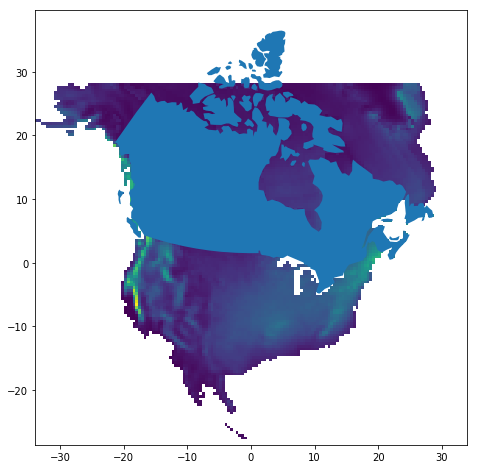

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(ens_mean, extent=[rlon.min(), rlon.max(), rlat.min(), rlat.max()], origin='lower')
canada.plot(ax=ax)

### Load the Station Data

In [15]:
stations = resource_filename("climpyrical", "tests/data/stations.csv")
df = pd.read_csv(stations, index_col=None)
df['rlon'], df['rlat'] = transform_coords(df['lon'].values, df['lat'].values)
df.head()

,id,SD_station_name,lat,lon,prov,elevation,SL50 (kPa),RL50 (kPa),rlon,rlat
0,15,CHEMAINUS,48.9350,-123.742,BC,75.0,2.0,0.763,-17.245771,4.407283
1,78,SAANICHTON CDA,48.6217,-123.419,BC,61.0,0.7,0.571,-17.148280,4.041212
2,91,SHAWNIGAN LAKE,48.6469,-123.626,BC,159.0,2.4,0.795,-17.269400,4.110152
3,109,VICTORIA GONZALES HTS,48.4131,-123.325,BC,69.5,0.8,0.371,-17.157965,3.823732
4,149,ALERT BAY,50.5833,-126.933,BC,59.4,1.4,0.565,-18.602266,6.674747


### Find Indices in rlon and rlat where stations lie

In [16]:
x_i, y_i = find_element_wise_nearest_pos(ds.rlon.values, ds.rlat.values, df.rlon.values, df.rlat.values)

/home/nannau/climpyrical-venv/lib/python3.6/site-packages/climpyrical/gridding.py:298: UserWarning: 36.222662646628834 is outside of array's domain between             -28.59999656677246 and 28.15999984741211. A station is outside of the CanRCM4 model grid space.
  .format(val, data.min(), data.max())
/home/nannau/climpyrical-venv/lib/python3.6/site-packages/climpyrical/gridding.py:298: UserWarning: 32.64541886648805 is outside of array's domain between             -28.59999656677246 and 28.15999984741211. A station is outside of the CanRCM4 model grid space.
  .format(val, data.min(), data.max())
/home/nannau/climpyrical-venv/lib/python3.6/site-packages/climpyrical/gridding.py:298: UserWarning: 31.345755932126362 is outside of array's domain between             -28.59999656677246 and 28.15999984741211. A station is outside of the CanRCM4 model grid space.
  .format(val, data.min(), data.max())
/home/nannau/climpyrical-venv/lib/python3.6/site-packages/climpyrical/gridding.py:298: UserW

### Find the model values in grids that stations fall on
Plot these model values against the station values - this should roughly resemble a 1:1 relationship. 

Text(0.5, 1.0, 'Model and Observations')

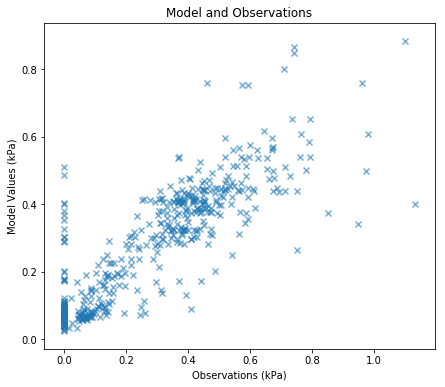

In [17]:
fig, ax = plt.subplots(figsize=(7, 6))

model = find_nearest_index_value(ds.rlon.values, ds.rlat.values, x_i, y_i, ens_mean, final_mask, ds)
observations = df['RL50 (kPa)'].values

ax.scatter(observations, model, marker='x', alpha = 0.6)
ax.set_xlabel("Observations (kPa)")
ax.set_ylabel("Model Values (kPa)")
ax.set_title("Model and Observations")